In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import re
import os
import glob 
import json
import joblib
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import clone

# XGBoost
import xgboost as xgb

# Scipy stats for parameter distributions
from scipy.stats import uniform, randint

# For plotting
import matplotlib.pyplot as plt

# Disable file validation warning
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Target options for reference
TARGET_OPTIONS = {
    'GINI': 'SI.POV.GINI',      # Gini coefficient (measure of inequality)
    'top10': 'SI.DST.10TH.10',  # Top 10% wealth share
    'bottom10': 'SI.DST.FRST.10' # Bottom 10% wealth share
}

In [2]:
print('Date ranges available:')
for file in glob.glob('input/imputed/*.csv'):
    date_start = file.split('/')[-1].split('.')[0].split('_')[-3]
    date_end = file.split('/')[-1].split('.')[0].split('_')[-1]
    print(f"{date_start}_to_{date_end}")

Date ranges available:
1970_to_2020
2000_to_2020


In [3]:
selected_target = 'bottom10'
selected_date_range = '2000_to_2020'

In [4]:
# Random seed for reproducibility
SEED = 20250406

# Target
TARGET = TARGET_OPTIONS[selected_target]

# Input paths
INPUT_DIR = 'input'
IMPUTED_DIR = f'{INPUT_DIR}/imputed'
TRANSFORMED_DIR = f'{INPUT_DIR}/transformed'
TRAIN_TEST_VAL_DIR = f'{INPUT_DIR}/train_test_val_NCV'
REFERENCE_DIR = 'output/reference'

# Data files
DATA_FILE = f'{IMPUTED_DIR}/df_wide_knn_imputed_{selected_date_range}.csv'
TARGET_FILE = f'{TRANSFORMED_DIR}/df_wide_targets_{selected_date_range}.csv'
INDICATOR_LOOKUP_FILE = f'{REFERENCE_DIR}/indicator_lookup.csv'

# Extract implied date range from data file name
DATE_RANGE = re.search(r'(\d+)_to_(\d+)', DATA_FILE).group(0)

# Set file suffix for output files based on the selected target
FILE_SUFFIX = f"{selected_target}_{DATE_RANGE}"

# Output paths
OUTPUT_DIR = 'output'
MODELS_DIR = f'{OUTPUT_DIR}/models_NCV'
PREDICTIONS_DIR = f'{OUTPUT_DIR}/predictions_NCV'
FEATURE_IMPORTANCE_DIR = f'{OUTPUT_DIR}/feature_importance_NCV'

# Output files
# - Base model outputs
MODEL_FILE = f'{MODELS_DIR}/xgb_base_model_{FILE_SUFFIX}.pkl'
PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_base_predictions_{FILE_SUFFIX}.csv'
FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_base_feature_importances_{FILE_SUFFIX}.csv'

# - Best model outputs
BEST_MODEL_FILE = f'{MODELS_DIR}/xgb_tuned_model_{FILE_SUFFIX}.pkl'
BEST_PREDICTIONS_FILE = f'{PREDICTIONS_DIR}/xgb_tuned_predictions_{FILE_SUFFIX}.csv'
BEST_FEATURE_IMPORTANCES_FILE = f'{FEATURE_IMPORTANCE_DIR}/xgb_tuned_feature_importances_{FILE_SUFFIX}.csv'
BEST_PARAMS_FILE = f'{MODELS_DIR}/xgb_tuned_model_params_{FILE_SUFFIX}.json'
TS_CV_FILE = f'{MODELS_DIR}/xgb_ts_cv_results_{FILE_SUFFIX}.pkl'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREDICTIONS_DIR, exist_ok=True)
os.makedirs(FEATURE_IMPORTANCE_DIR, exist_ok=True)
os.makedirs(TRAIN_TEST_VAL_DIR, exist_ok=True)

# Print configuration summary
print("\n=== CONFIGURATION SUMMARY ===")
print(f"Target Variable: {selected_target} ({TARGET})")
print(f"Date Range: {DATE_RANGE}")
print(f"Random Seed: {SEED}")
print("\n=== Input Files ===")
print(f"Data File: {DATA_FILE}")
print(f"Indicator Lookup: {INDICATOR_LOOKUP_FILE}")
print("\n=== Output Files ===")
print(f"Base Model: {MODEL_FILE}")
print(f"Base Predictions: {PREDICTIONS_FILE}")
print(f"Base Feature Importances: {FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model: {BEST_MODEL_FILE}")
print(f"Tuned Predictions: {BEST_PREDICTIONS_FILE}")
print(f"Tuned Feature Importances: {BEST_FEATURE_IMPORTANCES_FILE}")
print(f"Tuned Model Parameters: {BEST_PARAMS_FILE}")
print(f"Time Series CV Results: {TS_CV_FILE}")
print("\n=== Directories ===")
print(f"Input Directory: {INPUT_DIR}")
print(f"Imputed Data Directory: {IMPUTED_DIR}")
print(f"Transformed Data Directory: {TRANSFORMED_DIR}")
print(f"Train/Test/Val Directory: {TRAIN_TEST_VAL_DIR}")
print(f"Reference Directory: {REFERENCE_DIR}")
print(f"Output Directory: {OUTPUT_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Predictions Directory: {PREDICTIONS_DIR}")
print(f"Feature Importance Directory: {FEATURE_IMPORTANCE_DIR}")


=== CONFIGURATION SUMMARY ===
Target Variable: bottom10 (SI.DST.FRST.10)
Date Range: 2000_to_2020
Random Seed: 20250406

=== Input Files ===
Data File: input/imputed/df_wide_knn_imputed_2000_to_2020.csv
Indicator Lookup: output/reference/indicator_lookup.csv

=== Output Files ===
Base Model: output/models_NCV/xgb_base_model_bottom10_2000_to_2020.pkl
Base Predictions: output/predictions_NCV/xgb_base_predictions_bottom10_2000_to_2020.csv
Base Feature Importances: output/feature_importance_NCV/xgb_base_feature_importances_bottom10_2000_to_2020.csv
Tuned Model: output/models_NCV/xgb_tuned_model_bottom10_2000_to_2020.pkl
Tuned Predictions: output/predictions_NCV/xgb_tuned_predictions_bottom10_2000_to_2020.csv
Tuned Feature Importances: output/feature_importance_NCV/xgb_tuned_feature_importances_bottom10_2000_to_2020.csv
Tuned Model Parameters: output/models_NCV/xgb_tuned_model_params_bottom10_2000_to_2020.json
Time Series CV Results: output/models_NCV/xgb_ts_cv_results_bottom10_2000_to_202

#  time series nested cross-validation

In [5]:
# Load the data
try:
    print("Loading data...")
    data = pd.read_csv(DATA_FILE)
    targets = pd.read_csv(TARGET_FILE)
    print(f"Data loaded. Shape: {data.shape}, Targets shape: {targets.shape}")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")

Loading data...
Data loaded. Shape: (3844, 391), Targets shape: (5300, 3)


In [6]:
# Define functions for time series nested cross-validation

def plot_time_series_cv(data, n_splits=5):
    """Plot the time series cross-validation splits"""
    years = sorted(data['Year'].unique())
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    plt.figure(figsize=(15, n_splits * 2))
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(years)):
        train_years = [years[idx] for idx in train_idx]
        test_years = [years[idx] for idx in test_idx]
        
        plt.subplot(n_splits, 1, i+1)
        plt.scatter(train_years, [i] * len(train_years), 
                   c='blue', marker='o', label='Training')
        plt.scatter(test_years, [i] * len(test_years), 
                   c='red', marker='x', label='Testing')
        
        if i == 0:
            plt.legend()
        
        plt.title(f'Fold {i+1}')
        plt.xlabel('Year')
        plt.yticks([])
    
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/time_series_cv_splits.png', dpi=300)
    plt.show()

def time_series_nested_cv(data, targets, target_col, n_splits_outer=5, n_splits_inner=3):
    """
    Implements time series nested cross-validation with countries as nested structure.
    
    Args:
        data: DataFrame containing features and metadata (Country Code, Year)
        targets: DataFrame containing target variables
        target_col: Target column name
        n_splits_outer: Number of splits for outer CV loop
        n_splits_inner: Number of splits for inner CV loop
        
    Returns:
        Dictionary with train/val/test indices and datasets
    """
    print("Setting up time series nested cross-validation...")
    
    # Non-feature columns that should be excluded from model training
    non_feature_cols = ['Country Name', 'Country Code', 'Year']
    feature_columns = [col for col in data.columns if col not in non_feature_cols]
    
    # Sort data by year to respect time order
    data = data.sort_values('Year')
    data_index = data.index
    targets = targets.loc[data_index].copy()
    
    # Get unique years (for time series splits)
    years = data['Year'].unique()
    year_to_idx = {year: i for i, year in enumerate(years)}
    
    # Extract country codes for grouping
    countries = data['Country Code'].values
    
    # Time series outer splits
    tscv_outer = TimeSeriesSplit(n_splits=n_splits_outer)
    year_indices = np.array(range(len(years)))
    
    # Initialize dictionaries to store CV data
    cv_splits = {}
    
    # Generate the outer time series splits
    for fold_idx, (train_val_year_idx, test_year_idx) in enumerate(tscv_outer.split(year_indices)):
        train_val_years = years[train_val_year_idx]
        test_years = years[test_year_idx]
        
        # Get indices for data points in these years
        train_val_mask = data['Year'].isin(train_val_years)
        test_mask = data['Year'].isin(test_years)
        
        train_val_indices = data_index[train_val_mask]
        test_indices = data_index[test_mask]
        
        # Create inner time series splits
        tscv_inner = TimeSeriesSplit(n_splits=n_splits_inner)
        inner_splits = []
        
        # Get data for just the train/val years
        inner_years = train_val_years
        inner_year_indices = np.array(range(len(inner_years)))
        
        # Generate the inner time series splits
        for inner_train_year_idx, inner_val_year_idx in tscv_inner.split(inner_year_indices):
            inner_train_years = inner_years[inner_train_year_idx]
            inner_val_years = inner_years[inner_val_year_idx]
            
            # Get indices for data points in these years
            inner_train_mask = data.loc[train_val_indices, 'Year'].isin(inner_train_years)
            inner_val_mask = data.loc[train_val_indices, 'Year'].isin(inner_val_years)
            
            inner_train_indices = train_val_indices[inner_train_mask]
            inner_val_indices = train_val_indices[inner_val_mask]
            
            # Store these inner splits
            inner_splits.append((inner_train_indices, inner_val_indices))
        
        # Extract X and y data for this fold
        # Outer train/val set
        X_train_val = data.loc[train_val_indices, feature_columns].values
        y_train_val = targets.loc[train_val_indices, target_col].values
        
        # Outer test set
        X_test = data.loc[test_indices, feature_columns].values
        y_test = targets.loc[test_indices, target_col].values
        
        # Handle missing target values
        train_val_mask_no_nan = ~np.isnan(y_train_val)
        test_mask_no_nan = ~np.isnan(y_test)
        
        X_train_val_clean = X_train_val[train_val_mask_no_nan]
        y_train_val_clean = y_train_val[train_val_mask_no_nan]
        X_test_clean = X_test[test_mask_no_nan]
        y_test_clean = y_test[test_mask_no_nan]
        
        # Store the fold data
        cv_splits[f'fold_{fold_idx}'] = {
            'inner_splits': inner_splits,
            'train_val_indices': train_val_indices,
            'test_indices': test_indices,
            'X_train_val': X_train_val_clean,
            'y_train_val': y_train_val_clean,
            'X_test': X_test_clean,
            'y_test': y_test_clean,
            'train_val_years': train_val_years,
            'test_years': test_years
        }
        
        print(f"Fold {fold_idx}: Train/Val years {min(train_val_years)}-{max(train_val_years)}, " 
              f"Test years {min(test_years)}-{max(test_years)}")
        print(f"  Train/Val samples: {len(X_train_val_clean)}, Test samples: {len(X_test_clean)}")
    
    return {
        'cv_splits': cv_splits,
        'feature_columns': feature_columns,
        'data': data,
        'targets': targets
    }

def perform_nested_cv_hyperparameter_tuning(cv_data):
    """
    Performs hyperparameter tuning using the nested CV structure
    
    Args:
        cv_data: Dictionary with CV splits and data from time_series_nested_cv
        
    Returns:
        Dictionary with best models, parameters and evaluation metrics
    """
    print("\nPerforming nested cross-validation with hyperparameter tuning...")
    
    cv_splits = cv_data['cv_splits']
    feature_columns = cv_data['feature_columns']
    
    # Initialize result containers
    best_models = {}
    best_params = {}
    cv_metrics = {}
    feature_importances = {}
    
    # Define the parameter grid for tuning
    param_distributions = {
        'model__n_estimators': randint(50, 200),
        'model__learning_rate': uniform(0.01, 0.1),
        'model__max_depth': randint(2, 6),
        'model__min_child_weight': randint(1, 6),
        'model__gamma': uniform(0, 2),
        'model__subsample': uniform(0.7, 0.3),
        'model__colsample_bytree': uniform(0.7, 0.3),
        'model__colsample_bylevel': uniform(0.7, 0.3),
        'model__reg_alpha': uniform(0, 3),
        'model__reg_lambda': uniform(0.5, 3)
    }
    
    # Define the RMSE scorer
    rmse_scorer = make_scorer(
        lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
        greater_is_better=False
    )
    
    # Process each outer fold
    for fold_name, fold_data in cv_splits.items():
        print(f"\nProcessing {fold_name}...")
        
        # Get the data for this fold
        X_train_val = fold_data['X_train_val']
        y_train_val = fold_data['y_train_val']
        X_test = fold_data['X_test']
        y_test = fold_data['y_test']
        inner_splits = fold_data['inner_splits']
        
        # Prepare custom inner CV splits for sklearn
        class CustomSplitter:
            def __init__(self, splits):
                self.splits = splits
            
            def split(self, X, y=None, groups=None):
                for train_idx, val_idx in self.splits:
                    # Convert to array indices
                    train_array_idx = np.where(np.isin(range(len(X)), train_idx))[0]
                    val_array_idx = np.where(np.isin(range(len(X)), val_idx))[0]
                    yield train_array_idx, val_array_idx
            
            def get_n_splits(self, X=None, y=None, groups=None):
                return len(self.splits)
        
        # Create a pipeline with scaling and the model
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED))
        ])
        
        # Set up and run the randomized search
        inner_cv = CustomSplitter(inner_splits)
        random_search = RandomizedSearchCV(
            pipeline,
            param_distributions=param_distributions,
            n_iter=20,  # Number of parameter settings to try
            scoring=rmse_scorer,
            cv=inner_cv,
            random_state=SEED,
            n_jobs=-1,  # Use all processors
            verbose=1
        )
        
        # Fit the randomized search
        try:
            random_search.fit(X_train_val, y_train_val)
            
            # Get the best model and parameters
            best_model = random_search.best_estimator_
            best_param = random_search.best_params_
            
            # Evaluate on the test set
            y_test_pred = best_model.predict(X_test)
            test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
            test_r2 = r2_score(y_test, y_test_pred)
            
            # Store results
            best_models[fold_name] = best_model
            best_params[fold_name] = best_param
            
            # Extract and store feature importances
            importances = best_model.named_steps['model'].feature_importances_
            feature_importances[fold_name] = dict(zip(feature_columns, importances))
            
            # Store metrics
            cv_metrics[fold_name] = {
                'cv_score': -random_search.best_score_,  # Convert back to positive RMSE
                'test_rmse': test_rmse,
                'test_r2': test_r2,
                'test_years': fold_data['test_years']
            }
            
            print(f"  Best CV RMSE: {-random_search.best_score_:.4f}")
            print(f"  Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")
            print(f"  Test period: {min(fold_data['test_years'])}-{max(fold_data['test_years'])}")
            
        except Exception as e:
            print(f"Error in {fold_name}: {e}")
            continue
    
    # Determine the best overall model based on test RMSE
    if cv_metrics:
        best_fold = min(cv_metrics, key=lambda k: cv_metrics[k]['test_rmse'])
        
        # Calculate average metrics
        avg_cv_rmse = np.mean([metrics['cv_score'] for metrics in cv_metrics.values()])
        avg_test_rmse = np.mean([metrics['test_rmse'] for metrics in cv_metrics.values()])
        avg_test_r2 = np.mean([metrics['test_r2'] for metrics in cv_metrics.values()])
        
        print("\n=== Nested CV Results Summary ===")
        print(f"Average CV RMSE: {avg_cv_rmse:.4f}")
        print(f"Average Test RMSE: {avg_test_rmse:.4f}")
        print(f"Average Test R²: {avg_test_r2:.4f}")
        print(f"Best performing fold: {best_fold}")
        print(f"Best fold Test RMSE: {cv_metrics[best_fold]['test_rmse']:.4f}")
        print(f"Best fold Test R²: {cv_metrics[best_fold]['test_r2']:.4f}")
    else:
        best_fold = None
        print("No valid results obtained from cross-validation.")
    
    return {
        'best_models': best_models,
        'best_params': best_params,
        'cv_metrics': cv_metrics,
        'feature_importances': feature_importances,
        'best_fold': best_fold,
        'feature_columns': feature_columns
    }

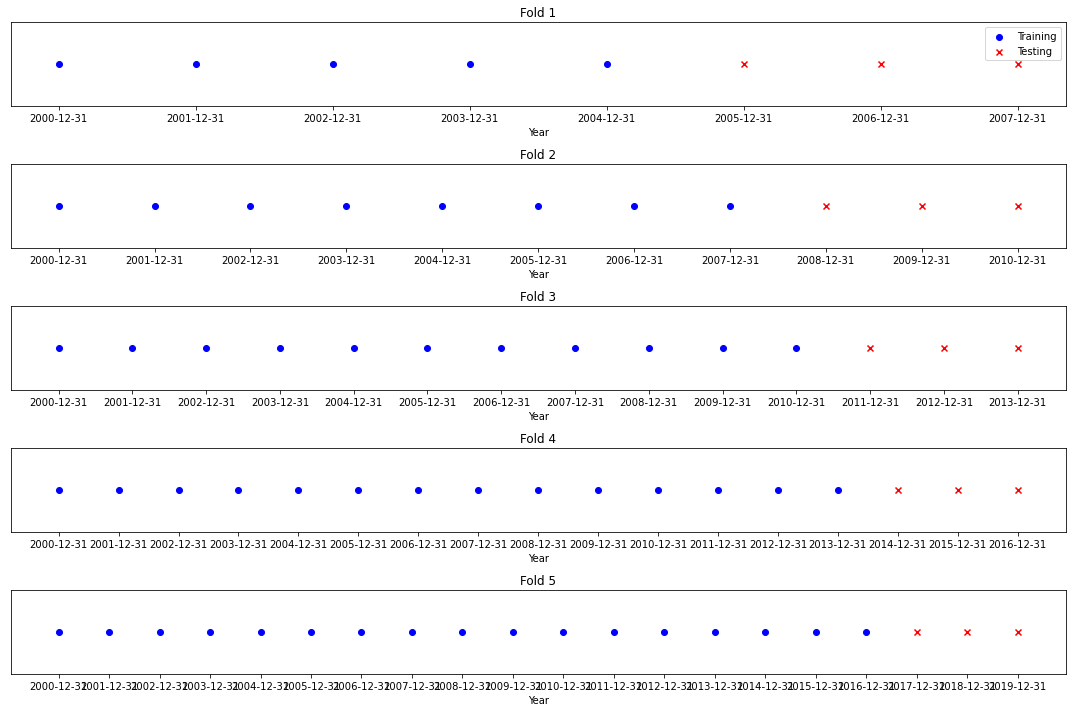

Setting up time series nested cross-validation...
Fold 0: Train/Val years 2000-12-31-2004-12-31, Test years 2005-12-31-2007-12-31
  Train/Val samples: 294, Test samples: 169
Fold 1: Train/Val years 2000-12-31-2007-12-31, Test years 2008-12-31-2010-12-31
  Train/Val samples: 463, Test samples: 155
Fold 2: Train/Val years 2000-12-31-2010-12-31, Test years 2011-12-31-2013-12-31
  Train/Val samples: 618, Test samples: 153
Fold 3: Train/Val years 2000-12-31-2013-12-31, Test years 2014-12-31-2016-12-31
  Train/Val samples: 771, Test samples: 145
Fold 4: Train/Val years 2000-12-31-2016-12-31, Test years 2017-12-31-2019-12-31
  Train/Val samples: 916, Test samples: 160

Performing nested cross-validation with hyperparameter tuning...

Processing fold_0...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
  Best CV RMSE: 0.8974
  Test RMSE: 0.6509, Test R²: 0.5423
  Test period: 2005-12-31-2007-12-31

Processing fold_1...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
 

In [ ]:
# Visualize the time series CV structure
plot_time_series_cv(data, n_splits=5)

# Perform time series nested cross-validation
cv_data = time_series_nested_cv(
    data, 
    targets, 
    TARGET, 
    n_splits_outer=5, 
    n_splits_inner=3
)

# Run hyperparameter tuning with nested CV
cv_results = perform_nested_cv_hyperparameter_tuning(cv_data)

# Save the CV results
joblib.dump(cv_results, TS_CV_FILE)
print(f"CV results saved to {TS_CV_FILE}")

# Get the best model from CV
if cv_results['best_fold'] is not None:
    best_fold = cv_results['best_fold']
    best_model = cv_results['best_models'][best_fold]
    best_params = cv_results['best_params'][best_fold]
    feature_columns = cv_results['feature_columns']
    
    # Save the best model
    joblib.dump(best_model, BEST_MODEL_FILE)
    print(f"Best model saved to {BEST_MODEL_FILE}")
    
    # Save the best parameters
    with open(BEST_PARAMS_FILE, 'w') as f:
        json.dump(best_params, f, indent=2)
    print(f"Best parameters saved to {BEST_PARAMS_FILE}")
    
    # Extract feature importances from the best model
    importances = best_model.named_steps['model'].feature_importances_
    feature_importances_df = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Save feature importances
    feature_importances_df.to_csv(BEST_FEATURE_IMPORTANCES_FILE, index=False)
    print(f"Feature importances saved to {BEST_FEATURE_IMPORTANCES_FILE}")
    
    # Get feature names with descriptions
    try:
        feature_lookup = pd.read_csv(INDICATOR_LOOKUP_FILE)
        feature_importances_with_names = feature_importances_df.merge(
            feature_lookup[['Indicator Code', 'Indicator Name']], 
            how='left', 
            left_on='Feature', 
            right_on='Indicator Code'
        )
        
        # Display top features
        print("\nTop 10 feature importances (best model):")
        display(feature_importances_with_names[['Indicator Code', 'Indicator Name', 'Importance']].head(10))
    except Exception as e:
        print(f"Error loading indicator lookup: {e}")
        print("\nTop 10 feature importances (best model):")
        display(feature_importances_df.head(10))
    
    # Final evaluation on the test set from the best fold
    fold_data = cv_data['cv_splits'][best_fold]
    X_test = fold_data['X_test']
    y_test = fold_data['y_test']
    
    # Generate predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    final_r2 = r2_score(y_test, y_pred)
    
    print(f"\nFinal evaluation on test set (years {min(fold_data['test_years'])}-{max(fold_data['test_years'])}):")
    print(f"RMSE: {final_rmse:.4f}")
    print(f"R²: {final_r2:.4f}")
    
    # Save predictions
    predictions_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    predictions_df.to_csv(BEST_PREDICTIONS_FILE, index=False)
    print(f"Predictions saved to {BEST_PREDICTIONS_FILE}")
else:
    print("No valid model found in cross-validation.")

In [ ]:
# SHAP analysis if we have a valid model
if cv_results['best_fold'] is not None:
    try:
        import shap
        
        print("\nPerforming SHAP analysis...")
        
        # Get the underlying XGBoost model from the pipeline
        xgb_model = best_model.named_steps['model']
        
        # Get a sample of test data for SHAP analysis (for efficiency)
        max_shap_samples = min(500, len(X_test))
        if len(X_test) > max_shap_samples:
            shap_indices = np.random.choice(len(X_test), max_shap_samples, replace=False)
            X_shap = X_test[shap_indices]
        else:
            X_shap = X_test
        
        # Apply the scaler to transform the data first
        X_shap_scaled = best_model.named_steps['scaler'].transform(X_shap)
        
        # Initialize SHAP explainer with the XGBoost model only
        explainer = shap.TreeExplainer(xgb_model)
        
        # Calculate SHAP values on the scaled data
        shap_values = explainer.shap_values(X_shap_scaled)
        
        # Save SHAP values
        shap_values_df = pd.DataFrame(shap_values, columns=feature_columns)
        shap_values_df.to_csv(f'{FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv', index=False)
        print(f"SHAP values saved to {FEATURE_IMPORTANCE_DIR}/shap_values_{FILE_SUFFIX}.csv")
        
        # Plot SHAP summary
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_shap_scaled, feature_names=feature_columns, show=False)
        plt.tight_layout()
        plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_summary_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Additionally, create a bar plot of SHAP values
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_shap_scaled, feature_names=feature_columns, plot_type="bar", show=False)
        plt.tight_layout()
        plt.savefig(f'{FEATURE_IMPORTANCE_DIR}/shap_importance_{FILE_SUFFIX}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create a SHAP importance summary by absolute value
        shap_pivot = pd.DataFrame(np.abs(shap_values)).mean(axis=0)
        shap_pivot = pd.DataFrame({
            'Feature': feature_columns,
            'SHAP Value': shap_pivot.values
        }).sort_values('SHAP Value', ascending=False)
        
        try:
            # Add feature descriptions if available
            shap_pivot_with_names = shap_pivot.merge(
                feature_lookup[['Indicator Code', 'Indicator Name', 'Topic']], 
                how='left', 
                left_on='Feature', 
                right_on='Indicator Code'
            )
            
            # Save and display
            shap_pivot_with_names.to_csv(f'{FEATURE_IMPORTANCE_DIR}/SHAP_top_features_{FILE_SUFFIX}.csv', index=False)
            print("\nTop 10 features by SHAP value magnitude:")
            display(shap_pivot_with_names[['Indicator Code', 'Indicator Name', 'Topic', 'SHAP Value']].head(10))
        except:
            # If lookup fails, just use feature codes
            shap_pivot.to_csv(f'{FEATURE_IMPORTANCE_DIR}/SHAP_top_features_{FILE_SUFFIX}.csv', index=False)
            print("\nTop 10 features by SHAP value magnitude:")
            display(shap_pivot.head(10))
            
    except ImportError:
        print("SHAP not available. Skipping SHAP analysis.")

In [ ]:
# Plot cross-validation results if we have a valid model
if cv_results['best_fold'] is not None:
    cv_metrics = cv_results['cv_metrics']
    
    # Extract metrics for plotting
    fold_names = list(cv_metrics.keys())
    cv_rmse = [cv_metrics[fold]['cv_score'] for fold in fold_names]
    test_rmse = [cv_metrics[fold]['test_rmse'] for fold in fold_names]
    test_r2 = [cv_metrics[fold]['test_r2'] for fold in fold_names]
    
    # Get test period for each fold
    test_periods = [f"{min(cv_data['cv_splits'][fold]['test_years'])}-{max(cv_data['cv_splits'][fold]['test_years'])}" 
                   for fold in fold_names]
    
    # Create a dataframe for easy display
    results_df = pd.DataFrame({
        'Fold': fold_names,
        'Test Period': test_periods,
        'CV RMSE': cv_rmse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2
    })
    
    # Save the results
    results_df.to_csv(f'{OUTPUT_DIR}/cv_performance_summary_{FILE_SUFFIX}.csv', index=False)
    
    print("\n=== Cross-Validation Performance Summary ===")
    display(results_df)
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    x = np.arange(len(fold_names))
    width = 0.35
    
    plt.bar(x - width/2, cv_rmse, width, label='CV RMSE')
    plt.bar(x + width/2, test_rmse, width, label='Test RMSE')
    
    plt.xlabel('Fold')
    plt.ylabel('RMSE')
    plt.title('Cross-Validation Performance')
    plt.xticks(x, [f"{fold}\n({period})" for fold, period in zip(fold_names, test_periods)])
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/cv_performance_{FILE_SUFFIX}.png', dpi=300)
    plt.show()
    
    # Plot R² values
    plt.figure(figsize=(12, 6))
    plt.bar(x, test_r2, width=0.5)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt